# 11. 폐렴 진단기 성능개선
---

## Step1 Set-up

### 1-1 라이브러리 import

In [69]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### 1-2 환경 셋팅

In [70]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## Step2 데이터 로드 및 준비

### 2-1 데이터 개수 확인

In [71]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### 2-2 train 데이터와 val 데이터 개수 조정

In [72]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### 2-3 train 데이터 안에 정상 이미지수와 폐렴 이미지 개수 확인

In [73]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0618-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person399_virus_793.jpeg


In [74]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


### 2-4 tf.data 인스턴스 생성

In [75]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

### 2-5 train 데이터셋, validation 데이터셋 개수 확인

In [76]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 2-6 라벨 데이터를 생성하는 함수 생성

In [77]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 2-7 이미지 형식 변경 및 사이즈 수정 함수 생성

In [78]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

### 2-8 train 데이터셋과 validation 데이터셋 만들기

In [79]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

### 2-9 이미지 사이즈 변경 및 라벨 확인

In [80]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


### 2-10 test 데이터셋 만들기 및 개수 확인

In [81]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 2-11 tf.data 파이프라인을 사용해 학습 데이터 효율적을 사용하는 함수 생성 및 적용

In [82]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step3 데이터 시각화

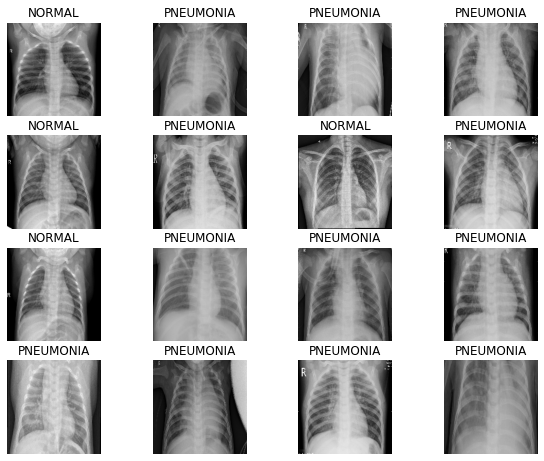

In [83]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step4 CNN 모델링

### 4-1 Convolution block 함수 생성

In [84]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### 4-2 Dense Block 함수 생성

In [85]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### 4-3 모델 빌드 함수 생성

In [86]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step5 데이터 imbalance 처리

In [87]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Step6 모델훈련

### 6-1 모델훈련 셋팅

In [88]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

### 6-2 모델학습

In [89]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 70s 226ms/step - loss: 0.5125 - accuracy: 0.7508 - precision: 0.9191 - recall: 0.7297 - val_loss: 0.7905 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 59s 225ms/step - loss: 0.2358 - accuracy: 0.9112 - precision: 0.9730 - recall: 0.9065 - val_loss: 1.2853 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 59s 228ms/step - loss: 0.1990 - accuracy: 0.9227 - precision: 0.9751 - recall: 0.9203 - val_loss: 0.1094 - val_accuracy: 0.9615 - val_precision: 0.9547 - val_recall: 0.9948
Epoch 4/25
261/261 [==============================] - 60s 229ms/step - loss: 0.1997 - accuracy: 0.9305 - precision: 0.9711 - recall: 0.9348 - val_loss: 0.0755 - val_accuracy: 0.9788 - val_precision: 0.9756 - val_recall: 0.9961
Epoch 5/25
261/261 [==============================] - 61s 234ms/step - loss: 0.1559 - accura

## Step7 결과확인

### 7-1 그래프를 통해 학습결과 확인

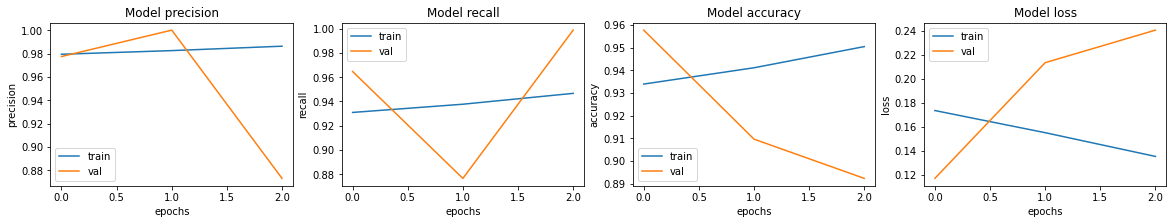

In [98]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 7-2 테스트 데이트를 통한 모델 평가

In [99]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 149ms/step - loss: 1.1991 - accuracy: 0.6619 - precision: 0.6489 - recall: 1.0000
Loss: 1.1990638971328735,
Accuracy: 0.6618589758872986,
Precision: 0.6489184498786926,
Recall: 1.0


## Step8 폐렴진단기 성능개선 - BATCH_SIZE 조정

In [100]:
# EarlyStopping은 특정 조건에서 훈련을 멈춤

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

### 8-1 BATCH_SIZE 32 조정

In [101]:
BATCH_SIZE = 32
EPOCHS = 50

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/50
130/130 [==============================] - 43s 267ms/step - loss: 0.1341 - accuracy: 0.9500 - precision: 0.9873 - recall: 0.9455 - val_loss: 0.1808 - val_accuracy: 0.9277 - val_precision: 0.9073 - val_recall: 1.0000
Epoch 2/50
130/130 [==============================] - 34s 266ms/step - loss: 0.1502 - accuracy: 0.9375 - precision: 0.9822 - recall: 0.9324 - val_loss: 0.0968 - val_accuracy: 0.9609 - val_precision: 0.9519 - val_recall: 0.9973
Epoch 3/50
130/130 [==============================] - 34s 266ms/step - loss: 0.1272 - accuracy: 0.9495 - precision: 0.9852 - recall: 0.9462 - val_loss: 0.2219 - val_accuracy: 0.9121 - val_precision: 0.9971 - val_recall: 0.8866
Epoch 4/50
130/130 [==============================] - 35s 272ms/step - loss: 0.1145 - accuracy: 0.9572 - precision: 0.9907 - recall: 0.9519 - val_loss: 0.2078 - val_accuracy: 0.9102 - val_precision: 1.0000 - val_recall: 0.8805
Epoch 00004: early stopping


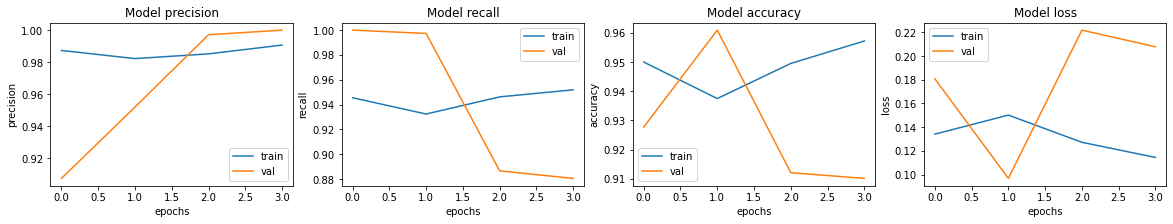

In [102]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [103]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 150ms/step - loss: 0.4999 - accuracy: 0.8381 - precision: 0.8247 - recall: 0.9410
Loss: 0.4998618960380554,
Accuracy: 0.8381410241127014,
Precision: 0.8247190713882446,
Recall: 0.9410256147384644


### 8-1 BATCH_SIZE 64 조정

In [104]:
BATCH_SIZE = 64
EPOCHS = 50

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/50
65/65 [==============================] - 31s 340ms/step - loss: 0.1247 - accuracy: 0.9577 - precision: 0.9866 - recall: 0.9560 - val_loss: 0.0613 - val_accuracy: 0.9805 - val_precision: 1.0000 - val_recall: 0.9742
Epoch 2/50
65/65 [==============================] - 22s 343ms/step - loss: 0.0991 - accuracy: 0.9548 - precision: 0.9920 - recall: 0.9476 - val_loss: 0.1344 - val_accuracy: 0.9531 - val_precision: 0.9368 - val_recall: 1.0000
Epoch 3/50
65/65 [==============================] - 22s 343ms/step - loss: 0.1487 - accuracy: 0.9548 - precision: 0.9813 - recall: 0.9571 - val_loss: 0.0366 - val_accuracy: 0.9922 - val_precision: 0.9944 - val_recall: 0.9944
Epoch 4/50
65/65 [==============================] - 23s 350ms/step - loss: 0.1019 - accuracy: 0.9731 - precision: 0.9921 - recall: 0.9715 - val_loss: 0.0720 - val_accuracy: 0.9766 - val_precision: 1.0000 - val_recall: 0.9691
Epoch 5/50
65/65 [==============================] - 23s 363ms/step - loss: 0.1091 - accuracy: 0.9596

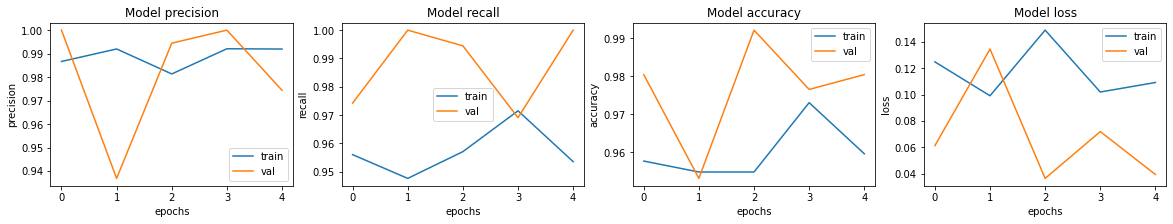

In [105]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [106]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 145ms/step - loss: 0.7902 - accuracy: 0.7772 - precision: 0.7381 - recall: 0.9974
Loss: 0.7901533842086792,
Accuracy: 0.7772436141967773,
Precision: 0.7381404042243958,
Recall: 0.9974358677864075


In [107]:
train_ds_aug = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_aug = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [108]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, num_parallel_calls=2) # augment 적용 부분이 배치처리 함수에 추가
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_aug = prepare_for_training_aug(train_ds_aug)
val_ds_aug = prepare_for_training_aug(val_ds_aug)

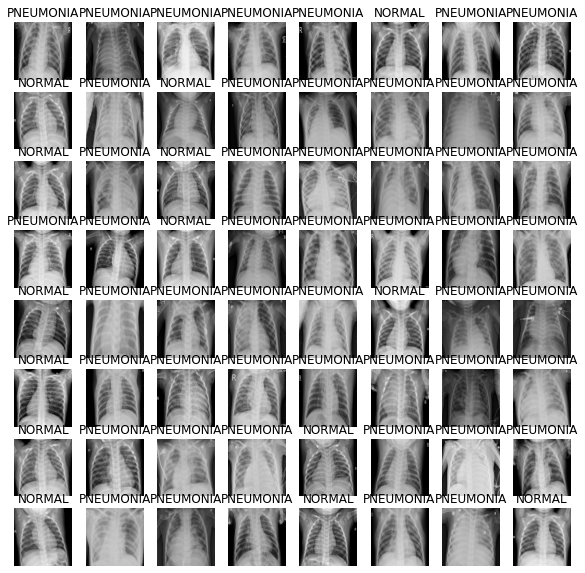

In [109]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(8,math.ceil(BATCH_SIZE/8),n+1) # 현재 배치사이즈 64
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch_aug, label_batch_aug = next(iter(train_ds_aug))
show_batch(image_batch_aug.numpy(), label_batch_aug.numpy())

In [110]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/50
65/65 [==============================] - 120s 904ms/step - loss: 0.0791 - accuracy: 0.9700 - precision: 0.9917 - recall: 0.9677 - val_loss: 0.0453 - val_accuracy: 0.9834 - val_precision: 0.9867 - val_recall: 0.9907
Epoch 2/50
65/65 [==============================] - 59s 912ms/step - loss: 0.0615 - accuracy: 0.9769 - precision: 0.9951 - recall: 0.9738 - val_loss: 0.0542 - val_accuracy: 0.9766 - val_precision: 0.9973 - val_recall: 0.9707
Epoch 3/50
65/65 [==============================] - 60s 931ms/step - loss: 0.0590 - accuracy: 0.9760 - precision: 0.9937 - recall: 0.9738 - val_loss: 0.0440 - val_accuracy: 0.9834 - val_precision: 0.9932 - val_recall: 0.9839
Epoch 4/50
65/65 [==============================] - 61s 951ms/step - loss: 0.0546 - accuracy: 0.9800 - precision: 0.9954 - recall: 0.9777 - val_loss: 0.0460 - val_accuracy: 0.9795 - val_precision: 0.9933 - val_recall: 0.9787
Epoch 5/50
65/65 [==============================] - 65s 1s/step - loss: 0.0466 - accuracy: 0.9822 -

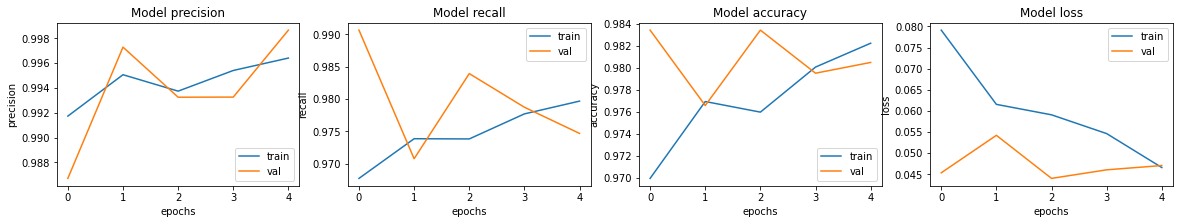

In [111]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [112]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 144ms/step - loss: 0.8103 - accuracy: 0.8093 - precision: 0.7683 - recall: 0.9949
Loss: 0.8102633357048035,
Accuracy: 0.8092948794364929,
Precision: 0.7683168053627014,
Recall: 0.9948717951774597


In [114]:
def dense_block2(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

In [116]:
def build_model2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block2(512, 0.7),
        dense_block2(128, 0.5),
        dense_block2(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [117]:
with tf.device('/GPU:0'):
    model2 = build_model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [118]:
with tf.device('/GPU:0'):
    history = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/50
65/65 [==============================] - 33s 340ms/step - loss: 0.4538 - accuracy: 0.7524 - precision: 0.9495 - recall: 0.7202 - val_loss: 0.6088 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000
Epoch 2/50
65/65 [==============================] - 22s 341ms/step - loss: 0.2767 - accuracy: 0.9125 - precision: 0.9650 - recall: 0.9137 - val_loss: 0.6146 - val_accuracy: 0.7773 - val_precision: 0.7773 - val_recall: 1.0000
Epoch 3/50
65/65 [==============================] - 22s 343ms/step - loss: 0.2315 - accuracy: 0.9143 - precision: 0.9781 - recall: 0.9071 - val_loss: 0.7177 - val_accuracy: 0.7031 - val_precision: 0.7031 - val_recall: 1.0000
Epoch 00003: early stopping


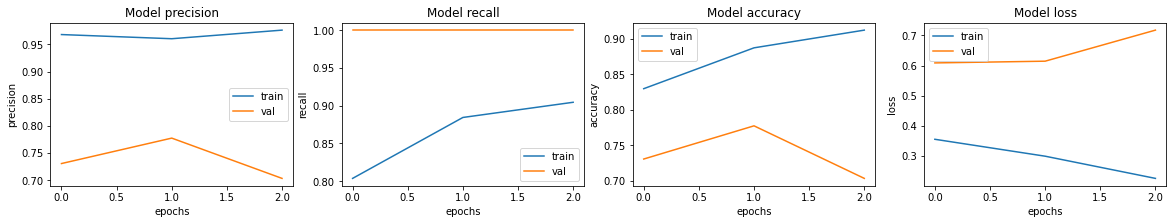

In [119]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [120]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 147ms/step - loss: 0.8727 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.8727035522460938,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [121]:
def dense_block3(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [122]:

def build_model3():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block3(512, 0.7),
        dense_block3(128, 0.5),
        dense_block3(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [123]:
with tf.device('/GPU:0'):
    model3 = build_model3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [124]:
with tf.device('/GPU:0'):
    history = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/50
65/65 [==============================] - 33s 343ms/step - loss: 0.6544 - accuracy: 0.6730 - precision: 0.7760 - recall: 0.8003 - val_loss: 0.6597 - val_accuracy: 0.6875 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 2/50
65/65 [==============================] - 22s 341ms/step - loss: 0.5358 - accuracy: 0.8152 - precision: 0.9343 - recall: 0.8170 - val_loss: 0.5632 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 3/50
65/65 [==============================] - 22s 340ms/step - loss: 0.3157 - accuracy: 0.8519 - precision: 0.9748 - recall: 0.8235 - val_loss: 0.7961 - val_accuracy: 0.2422 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
65/65 [==============================] - 22s 347ms/step - loss: 0.3228 - accuracy: 0.8370 - precision: 0.9794 - recall: 0.7898 - val_loss: 0.6767 - val_accuracy: 0.7734 - val_precision: 0.7734 - val_recall: 1.0000
Epoch 00004: early stopping


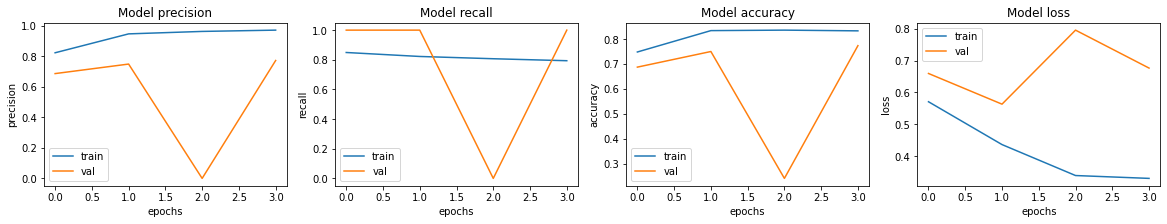

In [125]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [126]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 151ms/step - loss: 0.6858 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6858252286911011,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [127]:
def dense_block4(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
    ])
    
    return block

In [128]:
def build_model4():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block4(512, 0.7),
        dense_block4(128, 0.5),
        dense_block4(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [129]:
with tf.device('/GPU:0'):
    model4 = build_model4()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [130]:
with tf.device('/GPU:0'):
    history = model4.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/50
65/65 [==============================] - 33s 342ms/step - loss: 0.5186 - accuracy: 0.6299 - precision: 0.9517 - recall: 0.4909 - val_loss: 0.5899 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000
Epoch 2/50
65/65 [==============================] - 22s 338ms/step - loss: 0.2447 - accuracy: 0.9012 - precision: 0.9790 - recall: 0.8881 - val_loss: 0.6717 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/50
65/65 [==============================] - 22s 340ms/step - loss: 0.1841 - accuracy: 0.9057 - precision: 0.9786 - recall: 0.8942 - val_loss: 1.0958 - val_accuracy: 0.6953 - val_precision: 0.6953 - val_recall: 1.0000
Epoch 00003: early stopping


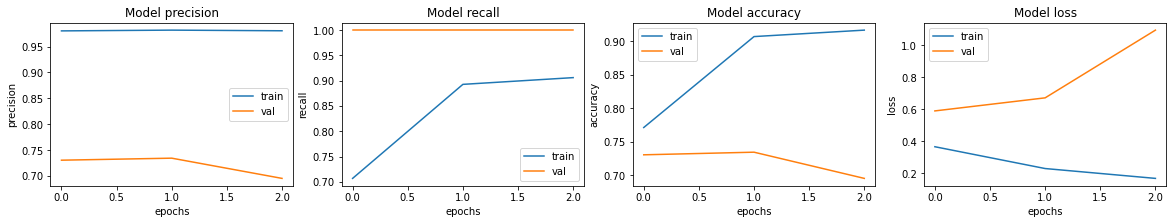

In [131]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [132]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 149ms/step - loss: 1.3421 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.3421202898025513,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0
